# Notes:-
* We looked at the C4.5 Algorithm and tried to get it working with all the ensemble methods, but it turned out to be too much of pain and not worth the effort.
* This code uses CART instead of c4.5. They both are pretty close to each other. Refer documentation for difference.
* This code uses SAMME.R for Adaboost instead of ADaboost.MI used for boosting in the paper.
* We did not purne the trees.
* This code takes really long time to finish (over 15 mins), hence we are not going to do a live demo of the code here. Here is a link to the code - https://github.com/ankitagarwal/cscie-81_presentation 

# Links to documentations
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.Bagging
* http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
* http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.fit

# CLEANING
* We are using datasets from the UCI repository.
* Lots of cleaning needed. Convert everything to a constant format to parse. Tab separate, comma separated, colon separated, etc
* Add missing headers
* Prep missing values using imputing.
* Categorical data needs to be mapped to dummy numerical values for trees to work properly.
* Some of classes in the datasets had too few elements, python complained about it during cross_validation_tests

In [27]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

# Import stuff
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.preprocessing import Imputer
import time

In [28]:
CSV_SEP = ','

# get list of datasets of UCI rep to use
def get_dataset_list():
    datasets = [
                'data/anneal.data.txt',
                'data/segment.dat.txt',
                'data/krkopt.data.txt',
                'data/house-votes-84.data.txt',
                'data/soybean-large.data.txt',
                'data/sat.trn.txt',
                'data/sonar.all-data.txt',
                'data/letter-recognition.data.txt',
                'data/winequality-white.csv',
                'data/winequality-red.csv'
                ]

    return datasets

In [29]:
names = dict()
names[0] = "Annealing (9)"
names[1] = "Voting (15)"
names[2] = "King Rook King Pawn (31)"
names[3] = "Soybean (6)"
names[4] = "Segment (4)"
names[5] = "Satellite (8)"
names[6] = "Sonar (1)"
names[7] = "Letter Recognition (2)"
names[8] = "Wine quality - white"
names[9] = "Wine quality - red"

In [30]:
# Do bagging.
# X : {array-like, sparse matrix} of shape = [n_samples, n_features]
# Y : array-like, shape = [n_samples]
def do_bagging(X, y):
    bagging = BaggingClassifier(DecisionTreeClassifier(), 200, 0.67, 1.0, True, True)
    return cross_val_score(bagging, X, y, cv=10)

# Do boosting
# X : {array-like, sparse matrix} of shape = [n_samples, n_features]
# Y : array-like, shape = [n_samples]
def do_boosting(X, y):
    boosting = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100)
    return cross_val_score(boosting, X, y, cv=10)

# Do Randomization
# X : {array-like, sparse matrix} of shape = [n_samples, n_features]
# Y : array-like, shape = [n_samples]
def do_randomization(X, y):
    random = ExtraTreesClassifier(200)
    return cross_val_score(random, X, y, cv=10)

# Do plain vanilla CART
# X : {array-like, sparse matrix} of shape = [n_samples, n_features]
# Y : array-like, shape = [n_samples]
def do_cart(X, y):
    cart = DecisionTreeClassifier()
    return cross_val_score(cart, X, y, cv=10)

In [33]:
# Convert accuracy scores to error rates.
def convert_to_error_rate(score):
    error = []
    for foldscore in score:
        errorscore = 1 - foldscore
        error.append(errorscore)
    return error

# Remove missing values from data and replace then with NaN for imputer to work.
def remove_missing_values(arr):
    X = arr
    for row_ind, row in enumerate(arr):
        for col_ind, element in enumerate(row):
            if (element == '?'):
                X[row_ind][col_ind] = float('NaN') #Fixed number to identify missing values.
    return X

# Convert categorical feature data to dummy values to CART can work.
def convert_categorical_data(arr):
    X = []

    for row_ind, row in enumerate(arr):
        # create a map from your variable names to unique integers:
        intmap = dict([(val, i) for i, val in enumerate(set(row))])
        # make the new array hold corresponding integers instead of strings:
        new_vals = [intmap[val] for val in row]
        X.append(new_vals)
    return X

# Helper function to measure time.
def time_fn( fn, *args, **kwargs ):
    start = time.clock()
    results = fn( *args, **kwargs )
    end = time.clock()
    fn_name = fn.__module__ + "." + fn.__name__
    print(fn_name + ": " + str(end-start) + "s")
    return [results, end-start]

In [34]:
# Main
scores = []
error_rates = []
mean_error_rates = []
mean_scores = []
meanTimes = []
for dataset_url in get_dataset_list():
    print("Testing: "+dataset_url)
    datascore = []
    dataerrorrate = []

    # Read data.
    df = pd.read_csv(dataset_url, CSV_SEP)

    # Remove non attribute columns.
    Y = df['class'].values
    if ('instance' in df):
        df.drop('instance', 1)
    df = df.drop('class', 1)

    # Prep data.
    df.fillna(df.mode().iloc[0])
    X = df.as_matrix()
    X = remove_missing_values(X)
    X = convert_categorical_data(X)
    imp = Imputer(strategy='most_frequent', axis=0)
    imp.fit(X, Y)
    X = imp.transform(X)

    # Get cross validation scores.
    cart_score, cartTime = time_fn(do_cart, X, Y)
    bagging_score, bagTime = time_fn(do_bagging, X, Y)
    boosting_score, boostTime = time_fn(do_boosting, X, Y)
    random_score, randomTime = time_fn(do_randomization, X, Y)

    print("Cart: {0} bag: {1} boost: {2} random: {3}".format(cartTime, bagTime, boostTime, randomTime))
    meanTimes.append([cartTime, bagTime, boostTime, randomTime])

    # Store scores.
    datascore.append(cart_score)
    datascore.append(bagging_score)
    datascore.append(boosting_score)
    datascore.append(random_score)
    scores.append(datascore)

    # Get error rates.
    cart_error = convert_to_error_rate(cart_score)
    bagging_error = convert_to_error_rate(bagging_score)
    boosting_error = convert_to_error_rate(boosting_score)
    random_error = convert_to_error_rate(random_score)

    # Store error rates.
    dataerrorrate.append(cart_error)
    dataerrorrate.append(bagging_error)
    dataerrorrate.append(boosting_error)
    dataerrorrate.append(random_error)
    error_rates.append(dataerrorrate)

    # Calculate mean error rates.

    mean_error_rates.append([np.mean(cart_error), np.mean(bagging_error), np.mean(boosting_error), np.mean(random_error)])
    mean_scores.append([np.mean(cart_score), np.mean(bagging_score), np.mean(boosting_score), np.mean(random_score)])

Testing: data/anneal.data.txt
__main__.do_cart: 0.039895000000001346s
__main__.do_bagging: 4.641249000000016s
__main__.do_boosting: 5.78560600000003s
__main__.do_randomization: 3.049171000000001s
Cart: 0.039895000000001346 bag: 4.641249000000016 boost: 5.78560600000003 random: 3.049171000000001
Testing: data/segment.dat.txt
__main__.do_cart: 0.12229000000002088s
__main__.do_bagging: 13.313612000000035s
__main__.do_boosting: 15.787127999999939s
__main__.do_randomization: 5.927720000000022s
Cart: 0.12229000000002088 bag: 13.313612000000035 boost: 15.787127999999939 random: 5.927720000000022
Testing: data/krkopt.data.txt
__main__.do_cart: 0.09788300000002437s
__main__.do_bagging: 9.937562999999955s
__main__.do_boosting: 15.643249000000083s
__main__.do_randomization: 5.564472000000023s
Cart: 0.09788300000002437 bag: 9.937562999999955 boost: 15.643249000000083 random: 5.564472000000023
Testing: data/house-votes-84.data.txt
__main__.do_cart: 0.020414999999957217s
__main__.do_bagging: 2.82080

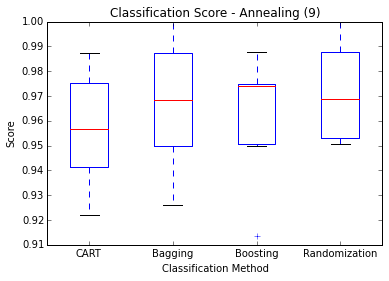

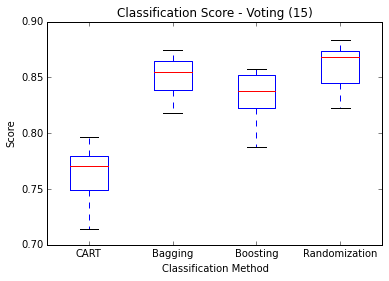

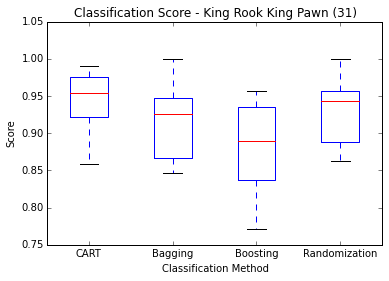

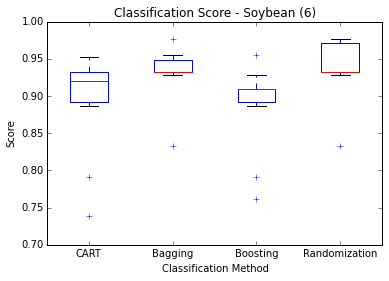

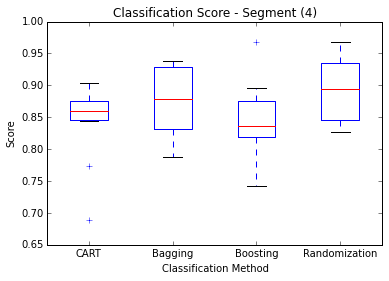

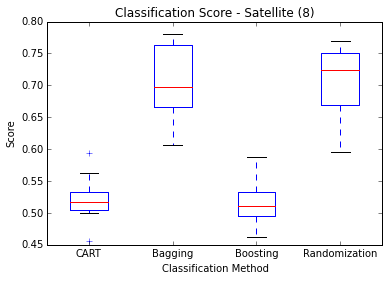

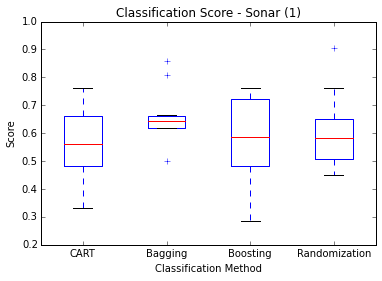

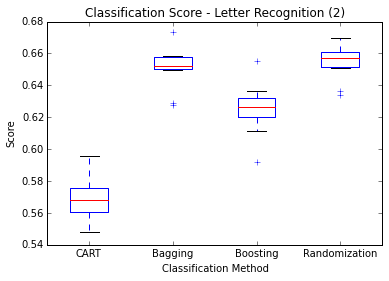

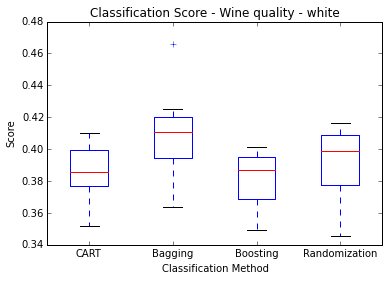

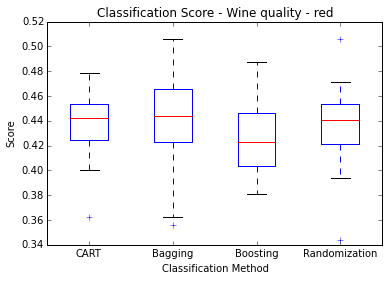

In [41]:
# Plot box plot - scores.
for idx, score in enumerate(scores):
    plt.boxplot(score, labels=['CART', 'Bagging', 'Boosting', 'Randomization'])
    plt.ylabel('Score')
    plt.xlabel('Classification Method')
    plt.title('Classification Score - ' + names[idx])
    plt.show()

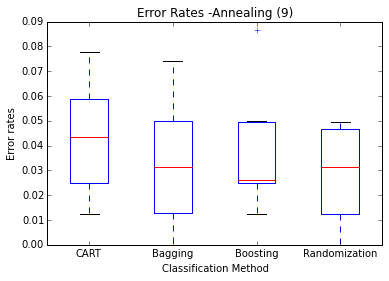

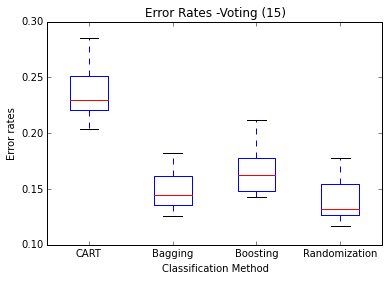

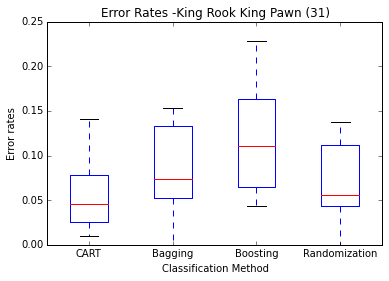

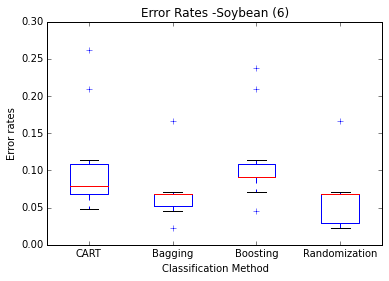

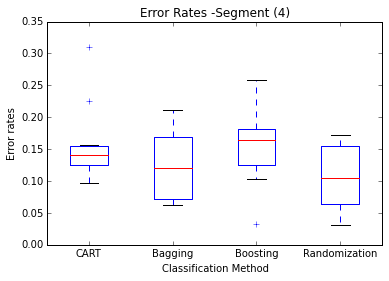

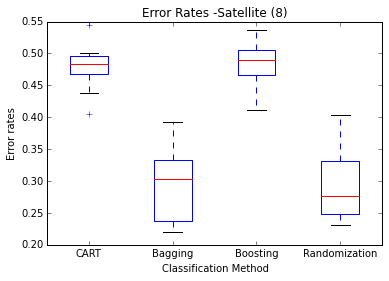

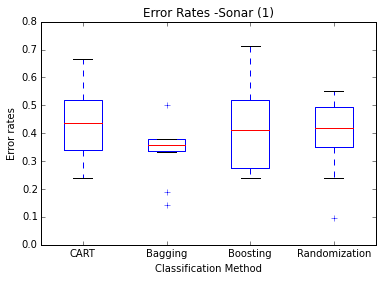

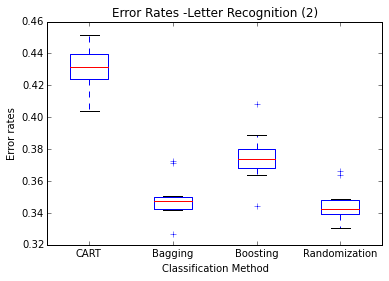

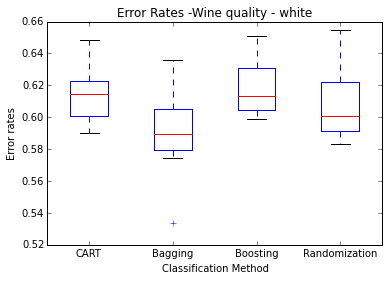

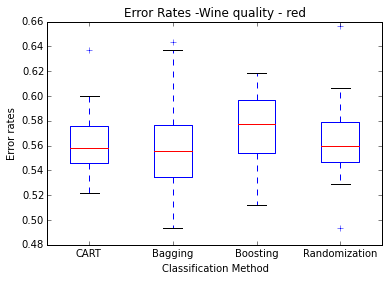

In [42]:
# Plot box plot - Error rates.
for idx, errorrate in enumerate(error_rates):
    plt.boxplot(errorrate, labels=['CART', 'Bagging', 'Boosting', 'Randomization'])
    plt.ylabel('Error rates')
    plt.xlabel('Classification Method')
    plt.title('Error Rates -' + names[idx])
    plt.show()

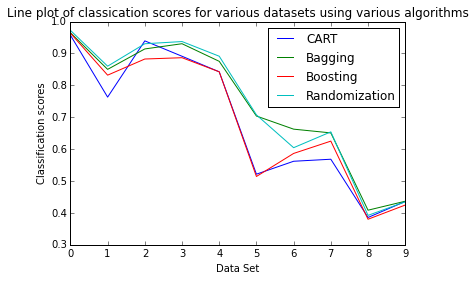

In [37]:
mean_scores = np.array(mean_scores)
plt.plot(mean_scores.T[0], label='CART')
plt.plot(mean_scores.T[1], label='Bagging')
plt.plot(mean_scores.T[2], label='Boosting')
plt.plot(mean_scores.T[3], label='Randomization')
plt.legend(loc='best')
plt.ylabel('Classification scores')
plt.xlabel('Data Set')
plt.title('Line plot of classication scores for various datasets using various algorithms')
plt.show()

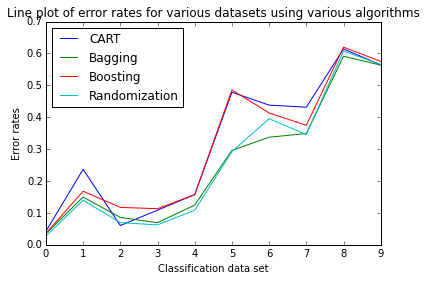

In [38]:
# Plot error rates of various algorithms
mean_error_rates = np.array(mean_error_rates)
plt.plot(mean_error_rates.T[0], label='CART')
plt.plot(mean_error_rates.T[1], label='Bagging')
plt.plot(mean_error_rates.T[2], label='Boosting')
plt.plot(mean_error_rates.T[3], label='Randomization')
plt.legend(loc='best')
plt.ylabel('Error rates')
plt.xlabel('Classification data set')
plt.title('Line plot of error rates for various datasets using various algorithms')
plt.show()

In [39]:

print("Average Times: ")
cartTime = np.mean([x[0] for x in meanTimes])
print("Cart: {0}".format(cartTime))
bagTime = np.mean([x[1] for x in meanTimes])
print("Bag: {0}".format(bagTime))
boostTime = np.mean([x[2] for x in meanTimes])
print("Boost: {0}".format(boostTime))
randomTime = np.mean([x[3] for x in meanTimes])
print("Random: {0}".format(randomTime))

Average Times: 
Cart: 0.24074750000000905
Bag: 24.57544759999996
Boost: 20.601785300000017
Random: 10.336142400000028


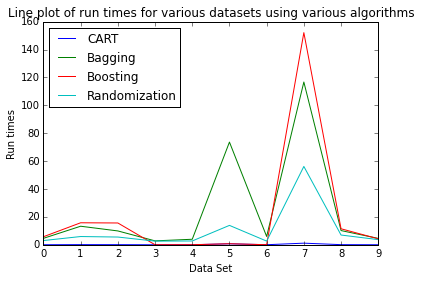

In [43]:
# Time chart
mean_times = np.array(meanTimes)
plt.plot(mean_times.T[0], label='CART')
plt.plot(mean_times.T[1], label='Bagging')
plt.plot(mean_times.T[2], label='Boosting')
plt.plot(mean_times.T[3], label='Randomization')
plt.legend(loc='best')
plt.ylabel('Run times')
plt.xlabel('Data Set')
plt.title('Line plot of run times for various datasets using various algorithms')
plt.show()